<a href="https://colab.research.google.com/github/ardbramantyo/DeepLearning-Defect-Detection/blob/main/Surface_Defect_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Created by: Ardian Kris Bramantyo

Date: May 20, 2022

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import zipfile
import cv2
from skimage import io
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
%matplotlib inline

## Import files from GDrive

In [2]:
import os
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_class = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data Science for Business/3. Manufacturing Data/train.csv')

In [4]:
df_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5748 entries, 0 to 5747
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        5748 non-null   object
 1   ClassId        5748 non-null   int64 
 2   EncodedPixels  5748 non-null   object
dtypes: int64(1), object(2)
memory usage: 134.8+ KB


In [5]:
df_class.head()

,ImageId,ClassId,EncodedPixels
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...


In [6]:
df_all = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data Science for Business/3. Manufacturing Data/defect_and_no_defect.csv')

In [7]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12997 entries, 0 to 12996
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImageID  12997 non-null  object
 1   label    12997 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 203.2+ KB


## Data Visualization

In [8]:
df_class['mask'] = df_class['ClassId'].map(lambda x:1)

In [9]:
df_class.head(10)

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...,1
5,17d02873a.jpg,3,254980 43 255236 127 255492 211 255748 253 256...,1
6,47b5ab1bd.jpg,3,128976 8 129230 12 129484 16 129739 23 129995 ...,1
7,a6ecee828.jpg,3,179011 27 179126 73 179259 39 179375 80 179497...,1
8,11aaf18e2.jpg,3,303235 2 303489 7 303743 9 303997 11 304181 2 ...,1
9,cdf669a1f.jpg,4,310246 11 310499 25 310753 28 311007 31 311262...,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of Images per Class')

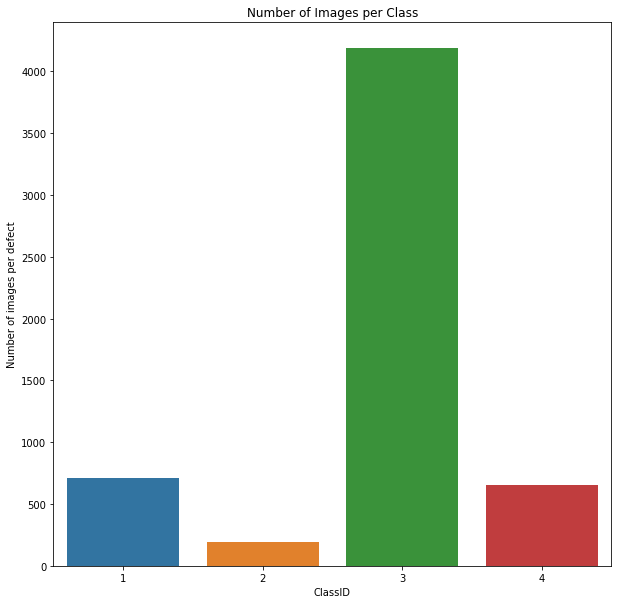

In [10]:
plt.figure(figsize=(10,10))
sns.countplot(df_class['ClassId'])
plt.ylabel('Number of images per defect')
plt.xlabel('ClassID')
plt.title('Number of Images per Class')

In [11]:
# Some of the images are classified more than 1 defect 
defect_type = df_class.groupby(['ImageId'])['mask'].sum()

In [12]:
defect_type

ImageId
0002cc93b.jpg    1
0007a71bf.jpg    1
000a4bcdd.jpg    1
000f6bf48.jpg    1
0014fce06.jpg    1
                ..
ffcf72ecf.jpg    1
fff02e9c5.jpg    1
fffe98443.jpg    1
ffff4eaa8.jpg    1
ffffd67df.jpg    1
Name: mask, Length: 5474, dtype: int64

In [13]:
defect_type.value_counts()

1    5201
2     272
3       1
Name: mask, dtype: int64

Text(0.5, 1.0, 'Number od defects in Image')

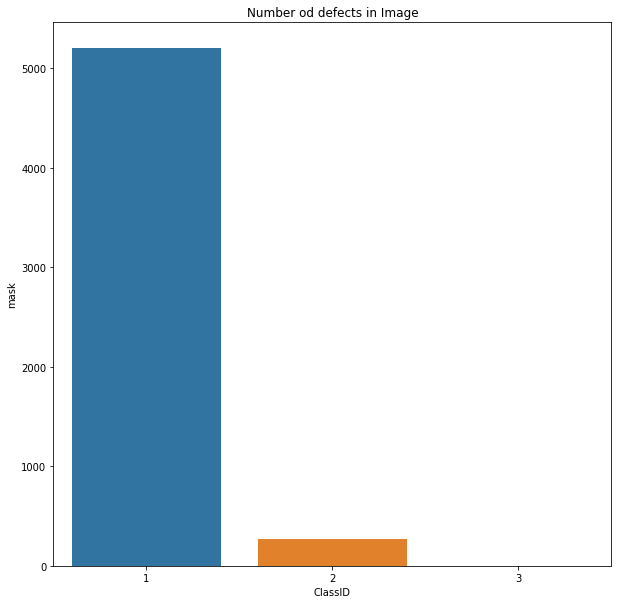

In [14]:
plt.figure(figsize=(10,10))
sns.barplot(x= defect_type.value_counts().index, y = defect_type.value_counts())
plt.xlabel('ClassID')
plt.title('Number od defects in Image')

In [15]:
df_class.shape #Only for defect images

(5748, 4)

In [16]:
df_all.shape #All images: defect-free and deffected

(12997, 2)

Text(0.5, 1.0, 'Defect and Non-Defect Images')

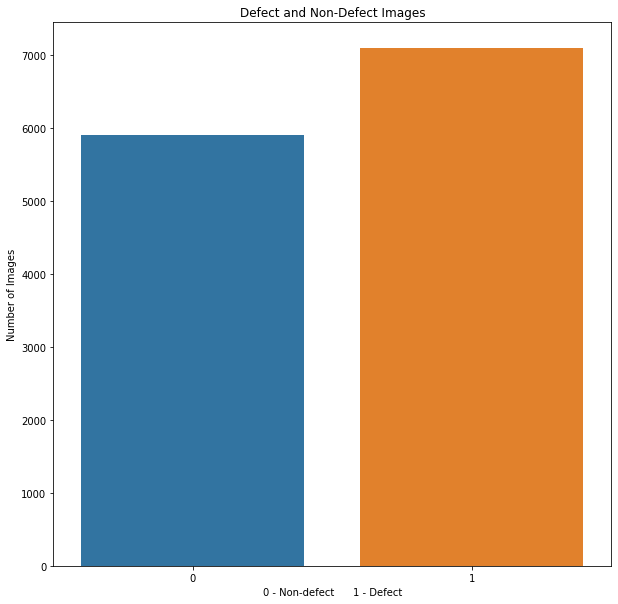

In [17]:
plt.figure(figsize=(10,10))
sns.barplot(x = df_all.label.value_counts().index, y = df_all.label.value_counts())
plt.ylabel('Number of Images')
plt.xlabel('0 - Non-defect      1 - Defect')
plt.title('Defect and Non-Defect Images')

Visualize Images with Defects

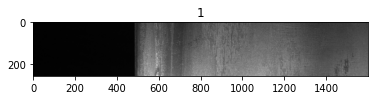

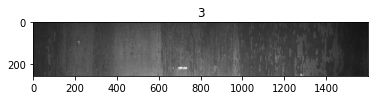

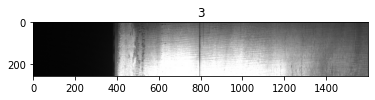

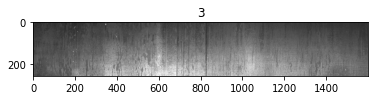

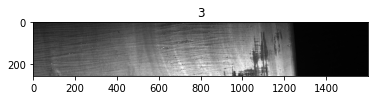

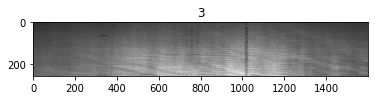

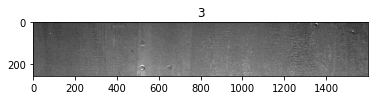

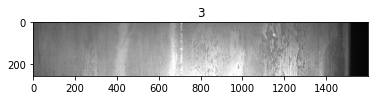

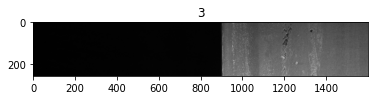

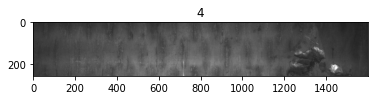

In [18]:
#Image size(256x1600)
from google.colab.patches import cv2_imshow
train_dir = '/content/drive/My Drive/Colab Notebooks/Data Science for Business/3. Manufacturing Data/train_images/'

for i in range(10):
  img = io.imread(os.path.join(train_dir, df_class.ImageId[i])) #Specify the path to the images given their image 10
  plt.figure()
  plt.title(df_class.ClassId[i])
  plt.imshow(img)
  #plt.axis('off')

Convert RLE to Mask

In [19]:
%cd /content/drive/My Drive/Colab Notebooks/Data Science for Business/3. Manufacturing Data/
from utilities import rle2mask, mask2rle

train_dir = '/content/drive/My Drive/Colab Notebooks/Data Science for Business/3. Manufacturing Data/train_images/'

/content/drive/My Drive/Colab Notebooks/Data Science for Business/3. Manufacturing Data


Using rle2mask on a sample defected image

In [20]:
image_index = 3
mask = rle2mask(df_class.EncodedPixels[image_index], img.shape[0], img.shape[1])
mask.shape

(256, 1600)

(-0.5, 1599.5, 255.5, -0.5)

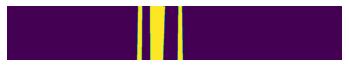

In [21]:
plt.imshow(mask)
plt.axis('off')

(-0.5, 1599.5, 255.5, -0.5)

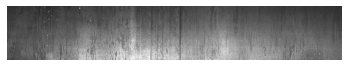

In [22]:
img = io.imread(os.path.join(train_dir, df_class.ImageId[image_index]))
plt.imshow(img)
img.shape
plt.axis('off')

Show the mask on top of the image

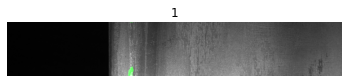

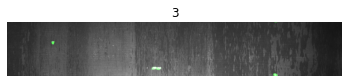

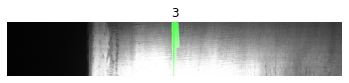

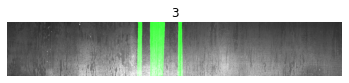

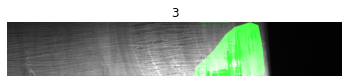

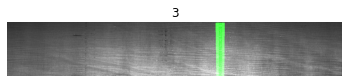

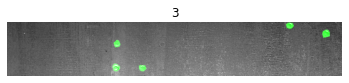

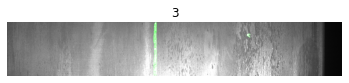

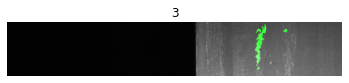

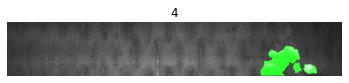

In [23]:
for i in range(10):
  # Read the images using openCV and convert to to RGB format 
  img = io.imread(os.path.join(train_dir, df_class.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #convert from BGR to RGB

  # Get the mask for the image from rle
  mask = rle2mask(df_class.EncodedPixels[i], img.shape[0], img.shape[1])

  # Color the pixels with values = 1
  img[mask == 1, 1] = 255
  plt.figure()
  plt.imshow(img)
  plt.title(df_class.ClassId[i])
  plt.axis('off')

Build and Train a Deep Learning Model to Detect Wether a Defect is Present in an Image or Not

In [24]:
df_all

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


In [25]:
# Use sklearn to divide the data into training and testing
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_all, test_size = 0.15)

In [26]:
train.shape

(11047, 2)

In [27]:
test.shape

(1950, 2)

In [28]:
train_dir = '/content/drive/My Drive/Colab Notebooks/Data Science for Business/3. Manufacturing Data/train_images/'

In [29]:
# Create an image generator fot the training and validation dataset
# Dividing data into training, validation, and testing

from keras_preprocessing.image import ImageDataGenerator

#Create a Data Generator which scales the Data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale = 1./255., validation_split = 0.15)

train_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = train_dir,
    x_col = 'ImageID',
    y_col = 'label',
    subset = 'training',
    batch_size = 16,
    shuffle = True,
    class_mode = 'other',
    target_size = (256, 256)
)

valid_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = train_dir,
    x_col = 'ImageID',
    y_col = 'label',
    subset = 'validation',
    batch_size = 16,
    shuffle = True,
    class_mode = 'other',
    target_size = (256, 256)
)

Found 9390 validated image filenames.
Found 1657 validated image filenames.


In [30]:
# Create data generator for test images
test_datagen = ImageDataGenerator(rescale = 1./255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test,
    directory = train_dir,
    x_col = 'ImageID',
    y_col = None,
    batch_size = 16,
    shuffle = False,
    class_mode = None,
    target_size = (256, 256)
)

Found 1950 validated image filenames.


Download Pre-Trained Model

In [31]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

94781440/94765736 [==============================] - 1s 0us/step


In [32]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [33]:
#freeze the model weights

for layer in basemodel.layers:
  layers.trainable = False


In [34]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(1, activation = 'sigmoid')(headmodel)

#concatenate basemodel & headmodel named model
model = Model(inputs = basemodel.input, outputs = headmodel)

In [35]:
model.compile(loss = 'binary_crossentropy', optimizer = 'Nadam', metrics =['accuracy'])

In [36]:
# Use EarlyStopping to exit traing if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience =20)

# Save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath='resnet-weights.hdf5', verbose = 1, save_best_only = True)

In [37]:
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 40, validation_data = valid_generator, validation_steps = valid_generator.n // 16, callbacks=[checkpointer, earlystopping] )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/40
586/586 [==============================] - ETA: 0s - loss: 0.5794 - accuracy: 0.7344 
Epoch 1: val_loss improved from inf to 0.73549, saving model to resnet-weights.hdf5
586/586 [==============================] - 7647s 13s/step - loss: 0.5794 - accuracy: 0.7344 - val_loss: 0.7355 - val_accuracy: 0.5413
Epoch 2/40
586/586 [==============================] - ETA: 0s - loss: 0.4166 - accuracy: 0.8074
Epoch 2: val_loss did not improve from 0.73549
586/586 [==============================] - 159s 271ms/step - loss: 0.4166 - accuracy: 0.8074 - val_loss: 0.7411 - val_accuracy: 0.5843
Epoch 3/40
586/586 [==============================] - ETA: 0s - loss: 0.3534 - accuracy: 0.8478
Epoch 3: val_loss did not improve from 0.73549
586/586 [==============================] - 159s 271ms/step - loss: 0.3534 - accuracy: 0.8478 - val_loss: 1.1042 - val_accuracy: 0.6590
Epoch 4/40
586/586 [==============================] - ETA: 0s - loss: 0.3258 - accuracy: 0.8596
Epoch 4: val_loss improved from 0

### Save the Trained Model Architecture

In [38]:
model_json = model.to_json()
with open('resnet-classifier-model.json','w') as json_file:
  json_file.write(model_json)

### Assess Train Model Performance

In [39]:
with open('/content/drive/My Drive/Colab Notebooks/Data Science for Business/3. Manufacturing Data/resnet-classifier-model.json', 'r') as json_file:
  json_savedModel = json_file.read()

#Load the Model
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('/content/drive/My Drive/Colab Notebooks/Data Science for Business/3. Manufacturing Data/resnet-weights.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics = ['accuracy'])

### Prediction Making

In [40]:
from keras_preprocessing.image import ImageDataGenerator

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose = 1)

121/121 [==============================] - 1281s 11s/step


In [41]:
test_predict

array([[1.0000000e+00],
       [2.6874841e-04],
       [9.0780614e-14],
       ...,
       [6.0948956e-33],
       [9.9728990e-01],
       [9.9995804e-01]], dtype=float32)

In [42]:
# Sigmoid activation will give the result values from 0 to 1.
# The network is initially used to classify wether the image has defect or not
# These images (defective) is passed through the segmentation network to get the localization and type of defect

predict = []

for i in test_predict:
  if i < 0.5:
    predict.append(0)
  else:
    predict.append(1)

predict = np.asarray(predict)


In [43]:
len(predict)

1936

In [44]:
# 1936 are get from test generator, due to batch size

original = np.asarray(test.label)[:1936]
len(original)

1936

### Find the Accuracy Score

In [45]:
#From the testing data
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.9106404958677686

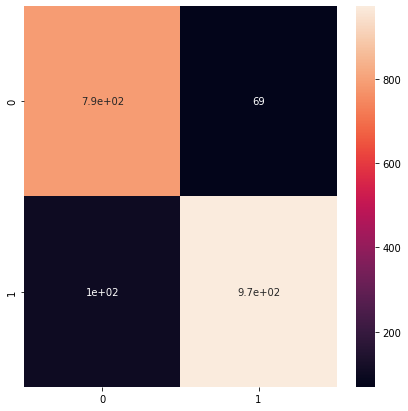

In [46]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot = True)

In [47]:
from sklearn.metrics import classification_report

report = classification_report(original,predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       859
           1       0.93      0.90      0.92      1077

    accuracy                           0.91      1936
   macro avg       0.91      0.91      0.91      1936
weighted avg       0.91      0.91      0.91      1936



Build A ResUnet Segmentation Model

In [63]:
#Data splitting into train and test
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(df_class, test_size = 0.2)

In [49]:
# Createing separate list imageId, classId and rle to pass into generator

train_ids = list(X_train.ImageId)
train_class = list(X_train.ClassId)
train_rle = list(X_train.EncodedPixels)

val_ids = list(X_val.ImageId)
val_class = list(X_val.ClassId)
val_rle = list(X_val.EncodedPixels)

In [50]:
from utilities import DataGenerator

#Creating Image Generators

training_generator = DataGenerator(train_ids, train_class, train_rle, train_dir)
validation_generator = DataGenerator(val_ids, val_class, val_rle, train_dir)

In [51]:
def resblock(X, f): #residual block
  
  # making a copy of input
  X_copy = X

  # Main Path
  X = Conv2D(f, kernel_size = (1,1), strides = (1,1), kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short Path
  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [52]:
# function to upscale and concatenating the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [53]:
input_shape = (256,256,1)

#Input tensor shape
X_input = Input(input_shape)

#Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

#Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

#Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

#Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

#Stage 5
conv5_in = resblock(pool_4, 256)

#Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

#Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

#Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

#Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

#Final Output
output = Conv2D(4, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output)

## Loss Function

In [54]:
%cd /content/drive/My Drive/Colab Notebooks/Data Science for Business/3. Manufacturing Data

from utilities import focal_tversky, tversky_loss, tversky

/content/drive/My Drive/Colab Notebooks/Data Science for Business/3. Manufacturing Data


In [55]:
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [61]:
# Using EarlyStopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="resunet-segmentation-weights.hdf5", verbose=1, save_best_only=True)

In [65]:
history = model_seg.fit_generator(training_generator, epochs = 40, validation_data= validation_generator, callbacks=[checkpointer, earlystopping])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/40


TypeError: ignored